In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


# Dataset

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Loading the MNIST train and test set
train_set = MNIST('./data/MNIST', download=True, train=True, transform=ToTensor())
test_set = MNIST('./data/MNIST', download=True, train=False, transform=ToTensor())

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


In [4]:
from torchvision.transforms import Compose, RandomAffine, ToTensor
from utils.data import PixelCorruption

# Defining the augmentations
t = Compose([
    RandomAffine(degrees=15,
                 translate=[0.1, 0.1],
                 scale=[0.9, 1.1],
                 shear=15), # Small affine transformations
    ToTensor(),             # Conversion to torch tensor
    PixelCorruption(0.8)    # PixelCorruption with keep probability 80%
])

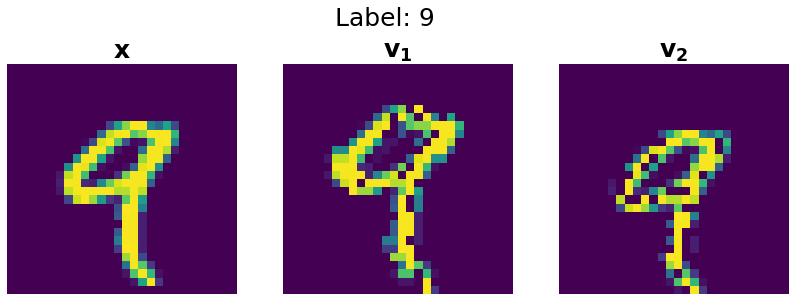

In [6]:
from utils.data import AugmentedDataset

# Creating the multi-view dataset
mv_train_set = AugmentedDataset(MNIST('./data/MNIST', train=True), t)

# Visualization original data and the two augmented views
f, ax = plt.subplots(1,3, figsize=(14,5))

idx = 4
v_1, v_2, y = mv_train_set[idx]
x, _ = train_set[idx]
f.suptitle('Label: %d'%y,size=25)

ax[0].set_title('$\\bf x$', size=25)
ax[0].imshow(x[0])

ax[1].set_title('$\\bf v_1$', size=25)
ax[1].imshow(v_1[0].data.numpy())

ax[2].set_title('$\\bf v_2$', size=25)
ax[2].imshow(v_2[0].data.numpy())


for a in ax:
    a.axis('off')

# Evaluation

In [7]:
from utils.evaluation import EmbeddedDataset
from utils.modules import Encoder
import os

# Encoder architecture
encoder = Encoder(z_dim = 64)

device = 'cuda' # Change to 'cpu' to perform the evaluation on CPU

encoder.eval()

Encoder(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=128, bias=True)
  )
)

VAE
-Embedding the dataset
-Computing classifier accuracy
InfoMax
-Embedding the dataset
-Computing classifier accuracy
MV-InfoMax
-Embedding the dataset
-Computing classifier accuracy
MIB
-Embedding the dataset
-Computing classifier accuracy


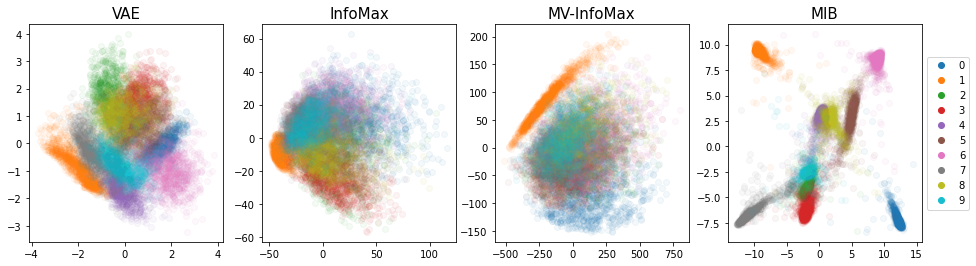

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from utils.evaluation import build_matrix

# Root containing the pre-trained models
model_path = 'trained_models'

# This comparison includes 
trained_models = [
    'VAE.pt',             # Beta Variational Autoencoder (Beta=4)
    'InfoMax.pt',         # InfoMax
    'MV-InfoMax.pt',      # Multi-View InfoMax
    'MIB.pt'              # Multi-View Information Bottleneck (Beta=1)
]
# The different models shown in this examples have been trained for a total of 1000 epochs

# Definition of axis and PCA for a qualitative visualization
f, ax = plt.subplots(1,len(trained_models),figsize=(len(trained_models) * 4, 4))
pca = PCA(n_components=2) 

# Definition of scaler and Logistic classifier used to evaluate the different representations
scaler = MinMaxScaler()
classifier = LogisticRegression(solver='saga', multi_class='multinomial', C=10, tol=.1)

# Each representation will be tested by training the logistic classifier on different
# number of given labels. In order to estimate the variance, each experiment
# will be performed 100 times on different balanced train sub-sets
repetitions = 100
examples_per_labels = [1, 2, 5, 10, 100, 1000]

accuracy_results = []

for i, model_file in enumerate(trained_models):    
    model_name = model_file.split('.')[0]
    print(model_name)
    
    # Load the parameters from a trained model
    state_dict = torch.load(os.path.join(model_path, model_file))['encoder']
    encoder.load_state_dict(state_dict)
    
    print('-Embedding the dataset')
        
    # Embed train and test set using the learned encoder
    embedded_train_set = EmbeddedDataset(base_dataset=train_set, encoder=encoder, device=device)
    embedded_test_set = EmbeddedDataset(base_dataset=test_set, encoder=encoder, device=device)
    
    # Convert the two sets into 2D matrices for evaluation
    X_train, Y_train = build_matrix(embedded_train_set)
    X_test, Y_test = build_matrix(embedded_test_set)
    
    # Project the test set on the principal components
    projected_X_test = pca.fit_transform(X_test)
    
    # And plot the representation with different colors corresponding to the different labels
    ax[i].set_title(model_name, size=15)
    for label in range(10):
        selected_X_test = projected_X_test[Y_test==label]
        ax[i].plot(selected_X_test[:,0], selected_X_test[:,1], 'o', label=label, alpha=0.05)
    
    print('-Computing classifier accuracy')
    
    # Scale train and test set
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Repeat multiple time to obtain a better estimation
    for i in range(repetitions):
        for examples_per_label in examples_per_labels:
            # Randomly select examples_per_label examples for each one of the 10 labels
            # to create a labeled training sub-set
            selected_ids = []
            for label in range(10):
                ids_with_label = np.arange(len(Y_train))[Y_train == label]
                selected_id = np.random.choice(ids_with_label, examples_per_label, replace=False)
                selected_ids.append(selected_id)
            selected_ids = np.concatenate(selected_ids)

            # Fit the linear classifier on the selection
            classifier.fit(X_train[selected_ids], Y_train[selected_ids])

            # Evaluate the classifier on the embedded test set
            test_accuracy = classifier.score(X_test, Y_test)

            accuracy_results.append({
                'Number of Labels': examples_per_label * 10,
                'Test Accuracy': test_accuracy,
                'Model': model_name
            })
    
    
# Add a legend to the last plot
leg = ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_marker('o')

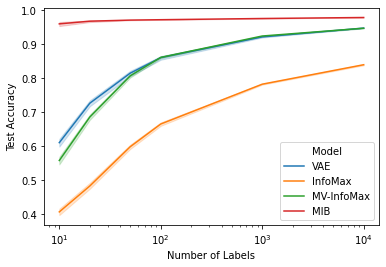

In [9]:
import pandas as pd
import seaborn as sns

# Visualize the accuracy of the classifier for different percentages of training labels
accuracy_results_df = pd.DataFrame(accuracy_results)

f, ax = plt.subplots(1,1)

sns.lineplot(data=accuracy_results_df, x='Number of Labels', y='Test Accuracy', hue='Model', ax=ax)
ax.set_xscale('log')